In [16]:
import numpy as np
import pandas as pd
import geopy.distance
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib notebook

## Preparing data

In [2]:
cities = pd.read_csv('data/cities.csv')

In [3]:
cities.head()

,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,...,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
0,385200.0,Респ,Адыгея,NaN,NaN,г,Адыгейск,NaN,NaN,100000200000,...,4: город,0,79403000000,7.970300e+10,107,UTC+3,44.878372,39.190172,Южный,12689
1,385000.0,Респ,Адыгея,NaN,NaN,г,Майкоп,NaN,NaN,100000100000,...,4: город,2,79401000000,7.970100e+10,105,UTC+3,44.609827,40.100653,Южный,144055
2,649000.0,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,NaN,NaN,400000100000,...,4: город,2,84401000000,8.470100e+07,400,UTC+7,51.958268,85.960296,Сибирский,62861
3,658125.0,край,Алтайский,NaN,NaN,г,Алейск,NaN,NaN,2200000200000,...,4: город,0,1403000000,1.703000e+06,2201,UTC+7,52.492091,82.779415,Сибирский,28528
4,656000.0,край,Алтайский,NaN,NaN,г,Барнаул,NaN,NaN,2200000100000,...,4: город,2,1401000000,1.701000e+06,2200,UTC+7,53.348115,83.779836,Сибирский,635585


In [4]:
data = cities.sort_values('Население', ascending=False)[:30]
data = data[['Город', 'Население', 'Широта', 'Долгота']]
data.head()

,Город,Население,Широта,Долгота
506,Москва,11514330,55.753879,37.620373
782,Санкт-Петербург,4848742,59.939125,30.315822
643,Новосибирск,1498921,55.028102,82.921057
828,Екатеринбург,1377738,56.838633,60.605489
615,Нижний Новгород,1250615,56.324209,44.005395


## Simulated annealing algorithm

In [5]:
def dist(path):
    dist = 0
    for i in range(len(path)):
        if i == len(path) - 1:
            j = 0
        else:
            j = i + 1
        coord1 = (data.loc[path[i]]['Широта'], data.loc[path[i]]['Долгота'])
        coord2 = (data.loc[path[j]]['Широта'], data.loc[path[j]]['Долгота'])
        dist += geopy.distance.vincenty(coord1, coord2).km
    return dist

def generate_new_sol(old_sol):
    i, j = 0, 0
    while (i == j):
        i, j = np.random.randint(low=0, high=len(old_sol) - 1, size = 2)
    new_sol = list(old_sol)
    new_sol[i] = old_sol[j]
    new_sol[j] = old_sol[i]
    return new_sol

def p_star(path, temp):
    return np.exp(- dist(path) / temp)

In [12]:
def sim_anneal(a_rate = 0.99):
    path_init = list(data.index)
    dist_init = dist(path_init)
    t = 0
    T = dist_init / 2
    sols = [[dist_init, path_init, T]]
    while T > 1:
        path_new = generate_new_sol(path_init)
        dist_new = dist(path_new)
        delta_dist = dist_new - dist_init
        alpha = np.exp(- (delta_dist / T))
        u = np.random.uniform()
        if u <= alpha:
            path_init = path_new
            dist_init = dist_new
        T = T * a_rate
        t += 1
        sols.append([dist_init, path_init, T])
    print(f'Sim anneal with {a_rate} rate done!')
    return dist_init, path_init, sols, t

## Showing results

In [18]:
def plot_sol(path):
    fig, ax = plt.subplots(figsize=(10, 5))

    x = [data.loc[i]['Долгота'] for i in path + [path[0]]]
    y = [data.loc[i]['Широта'] for i in path + [path[0]]]
    labels = {}
    labels = [data.loc[i]['Город'] for i in path]

    ax.plot(x, y)
    ax.set_title(f'Path distance: {dist(path):.2f}')
    for label, x, y in zip(labels, x, y):
        ax.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
    plt.show()

def show_results(rate, sol):
    print(f'Annealing rate is {rate}')
    print(f'Found solution is {sol[0]}')
    print(f'Took {sol[3]} iterations')
    fig, ax = plt.subplots()
    ax.plot([v[0] for v in sol[2]]) 
    plt.show()
    plot_sol(sol[1])

## Run algorithm with experimenting on different values of annealing rate

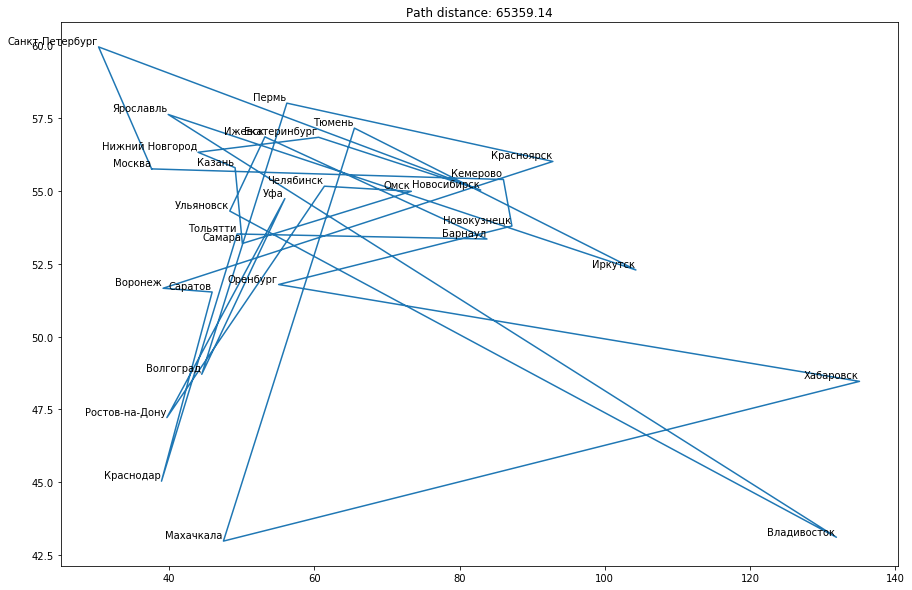

In [8]:
# Initial solution

plot_sol(list(data.index))

In [13]:
sols = {}
for i in (0.990, 0.995, 0.999, 0.9995):
    sols[i] = sim_anneal(i)

Sim anneal with 0.99 rate done!
Sim anneal with 0.995 rate done!
Sim anneal with 0.999 rate done!
Sim anneal with 0.9995 rate done!


Annealing rate is 0.99
Found solution is 25754.210889027585
Took 1035 iterations


<IPython.core.display.Javascript object>


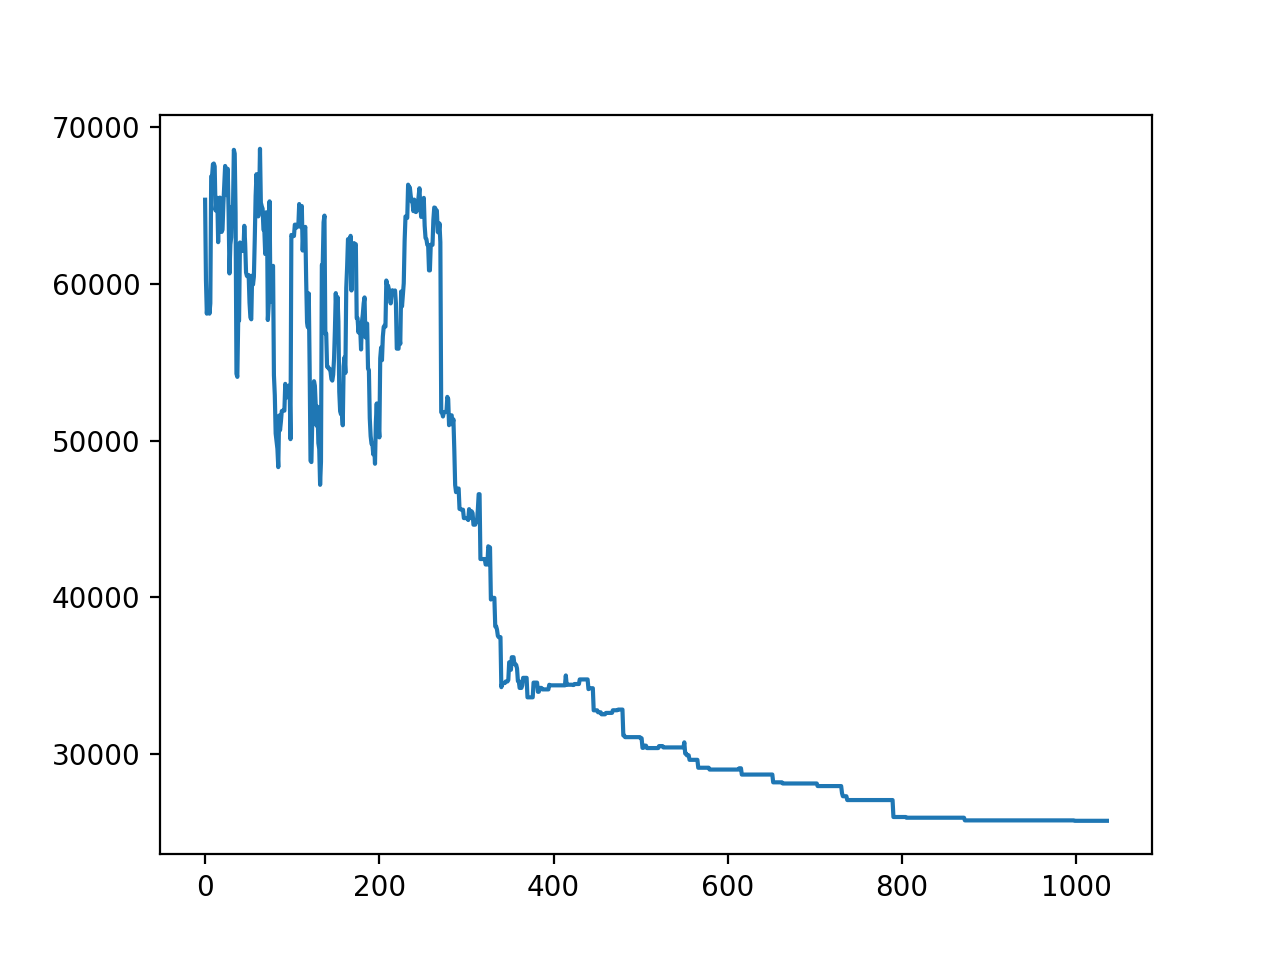

<IPython.core.display.Javascript object>


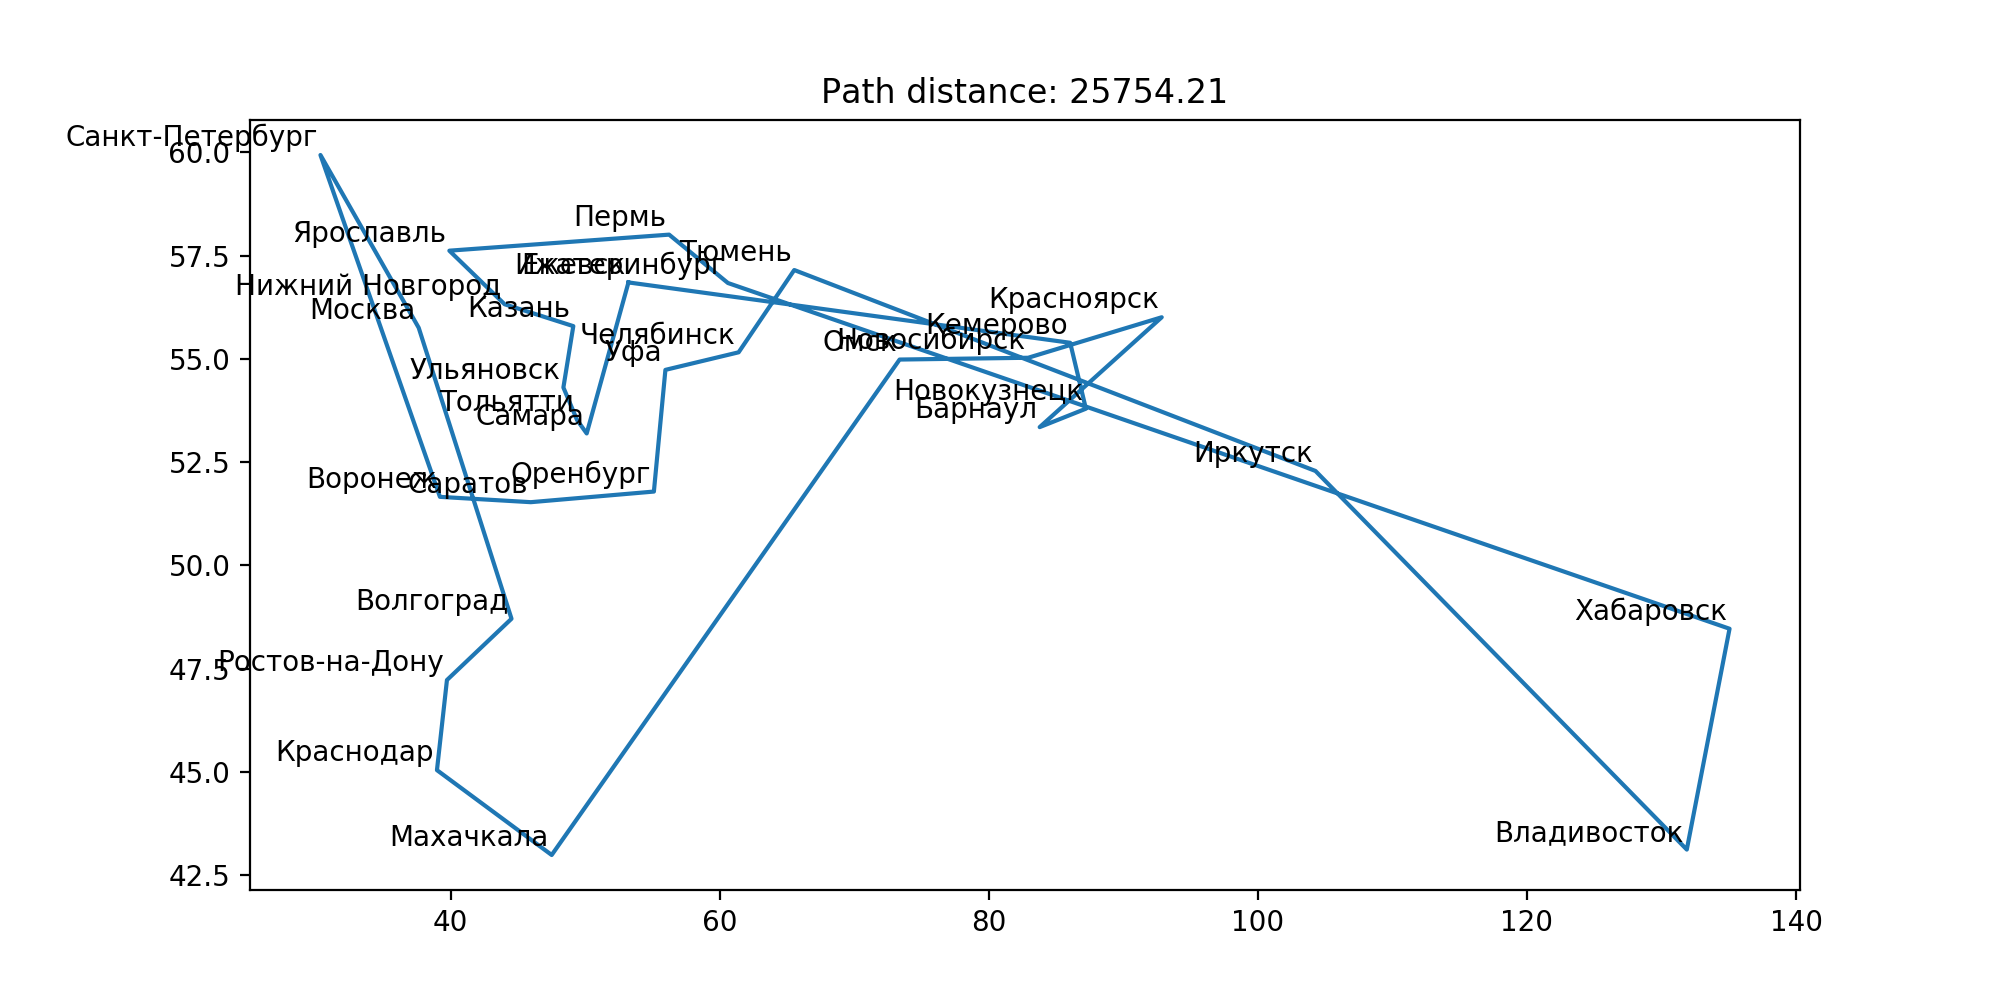

<IPython.core.display.Javascript object>


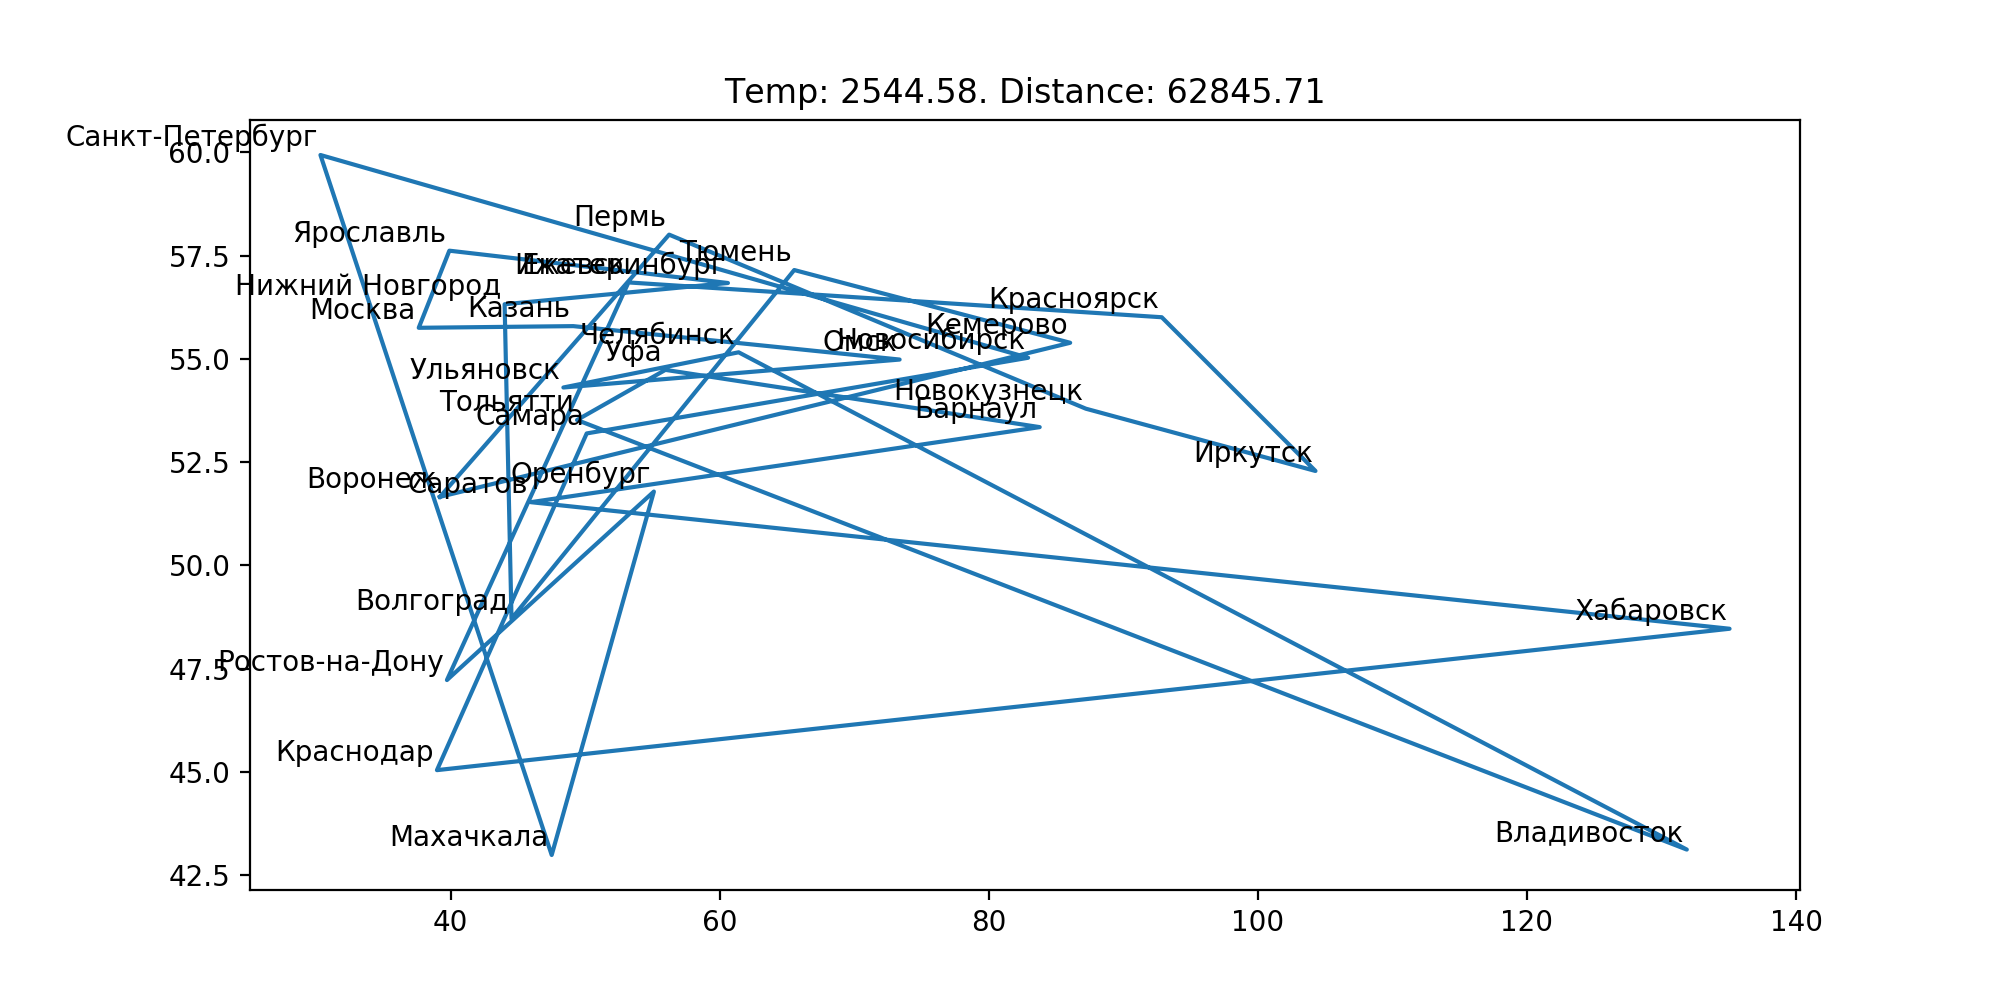

In [20]:
sol = sols[0.99]

show_results(0.99, sol)

paths = [v[1] for v in sol[2]]
temps = [v[2] for v in sol[2]]
dists = [v[0] for v in sol[2]]
labels = [data.loc[i]['Город'] for i in paths[0]]

fig, ax = plt.subplots(figsize=(10, 5))

x = [data.loc[i]['Долгота'] for i in paths[0] + [paths[0][0]]]
y = [data.loc[i]['Широта'] for i in paths[0] + [paths[0][0]]]
line, = ax.plot(x, y)
ax.set_title(f'Temp: {temps[0]:.2f}. Distance: {dists[0]:.2f}')
for label, x, y in zip(labels, x, y):
    ax.annotate(
        label,
        xy=(x, y), xytext=(-1, 1),
        textcoords='offset points', ha='right', va='bottom')

def animate(i):
    line.set_ydata([data.loc[j]['Широта'] for j in paths[i] + [paths[i][0]]]) 
    line.set_xdata([data.loc[j]['Долгота'] for j in paths[i] + [paths[i][0]]])
    ax.set_title(f'Temp: {temps[i]:.2f}. Distance: {dists[i]:.2f}')
    return line,


ani = animation.FuncAnimation(
    fig, animate, interval=1, blit=True, save_count=50)

plt.show()

Annealing rate is 0.995
Found solution is 22821.745493149865
Took 2074 iterations


<IPython.core.display.Javascript object>


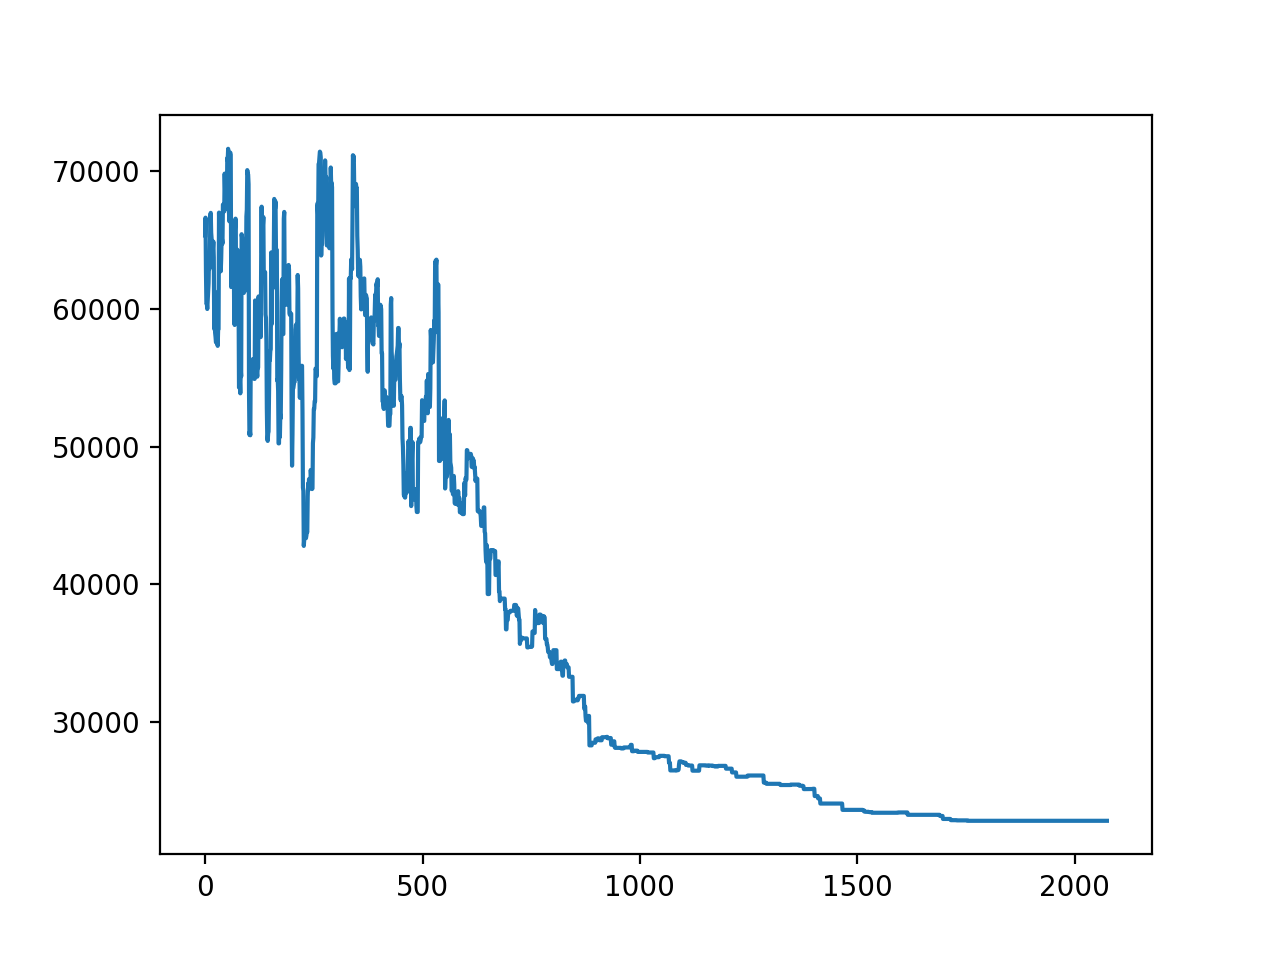

<IPython.core.display.Javascript object>


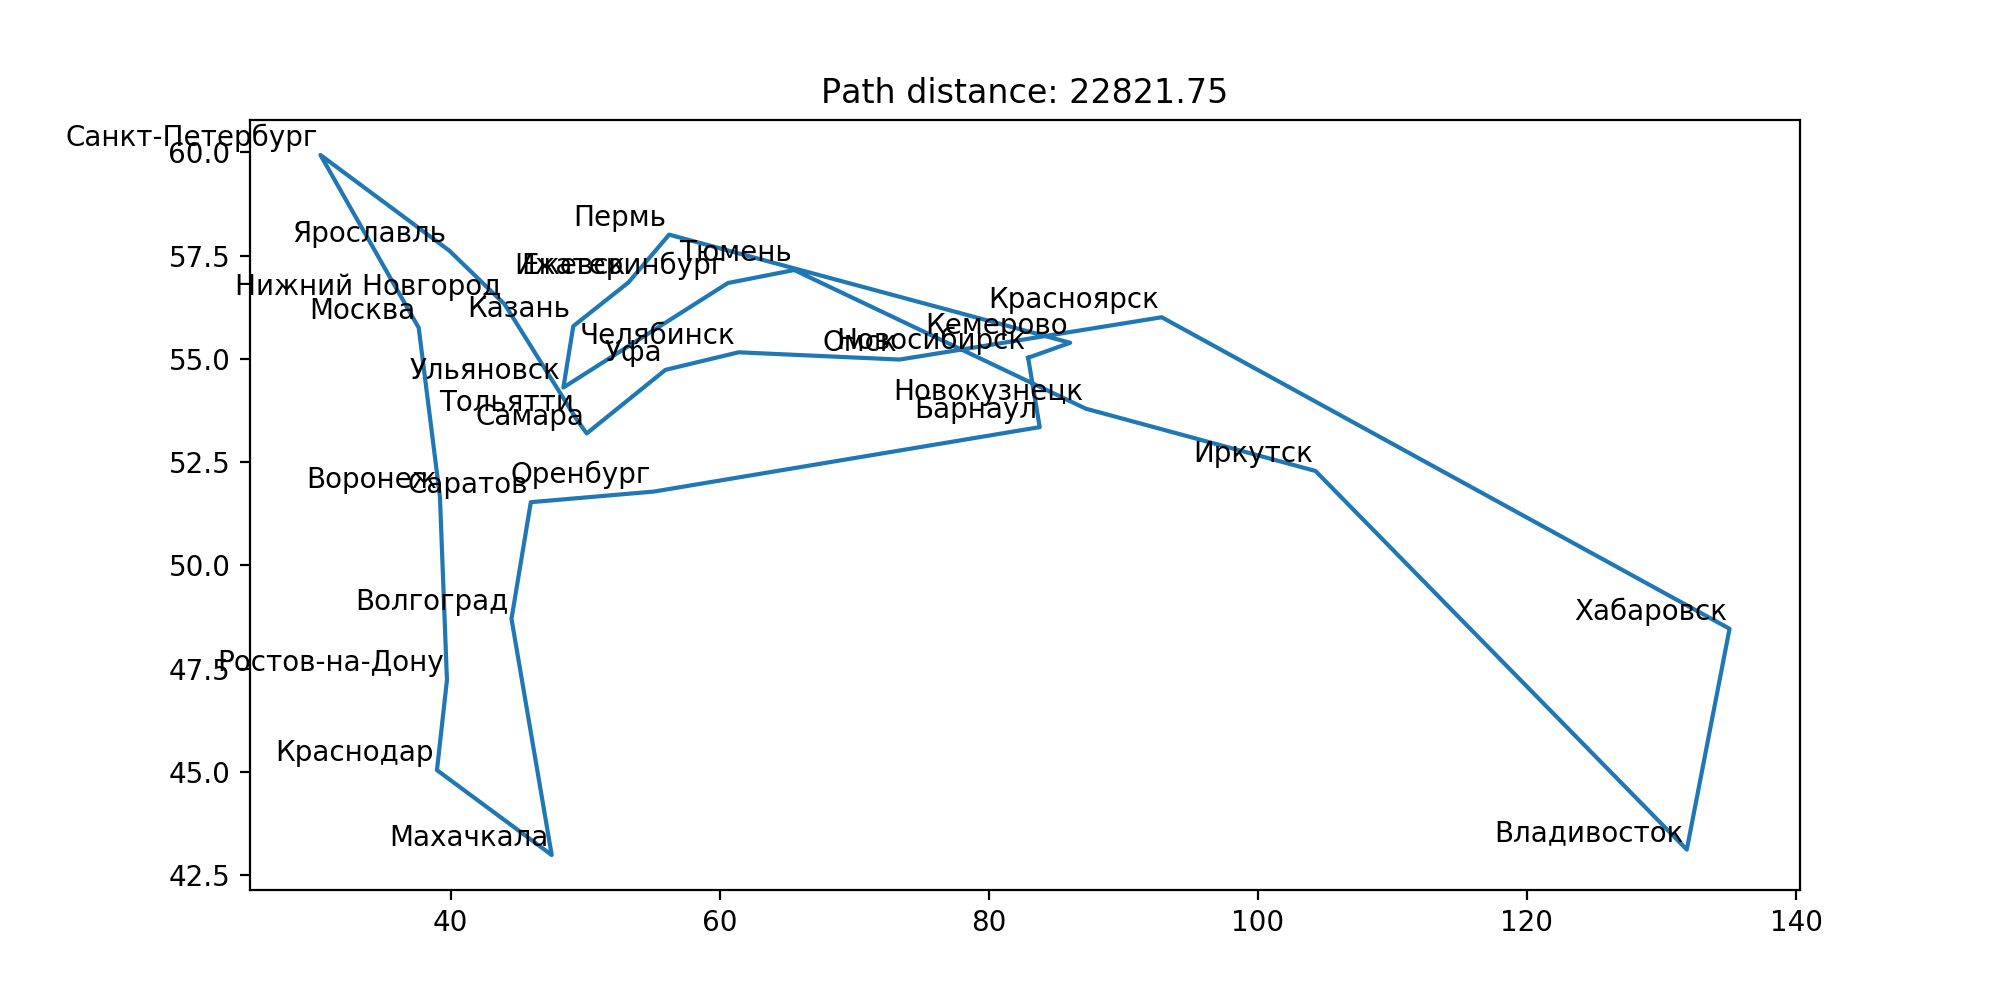

<IPython.core.display.Javascript object>


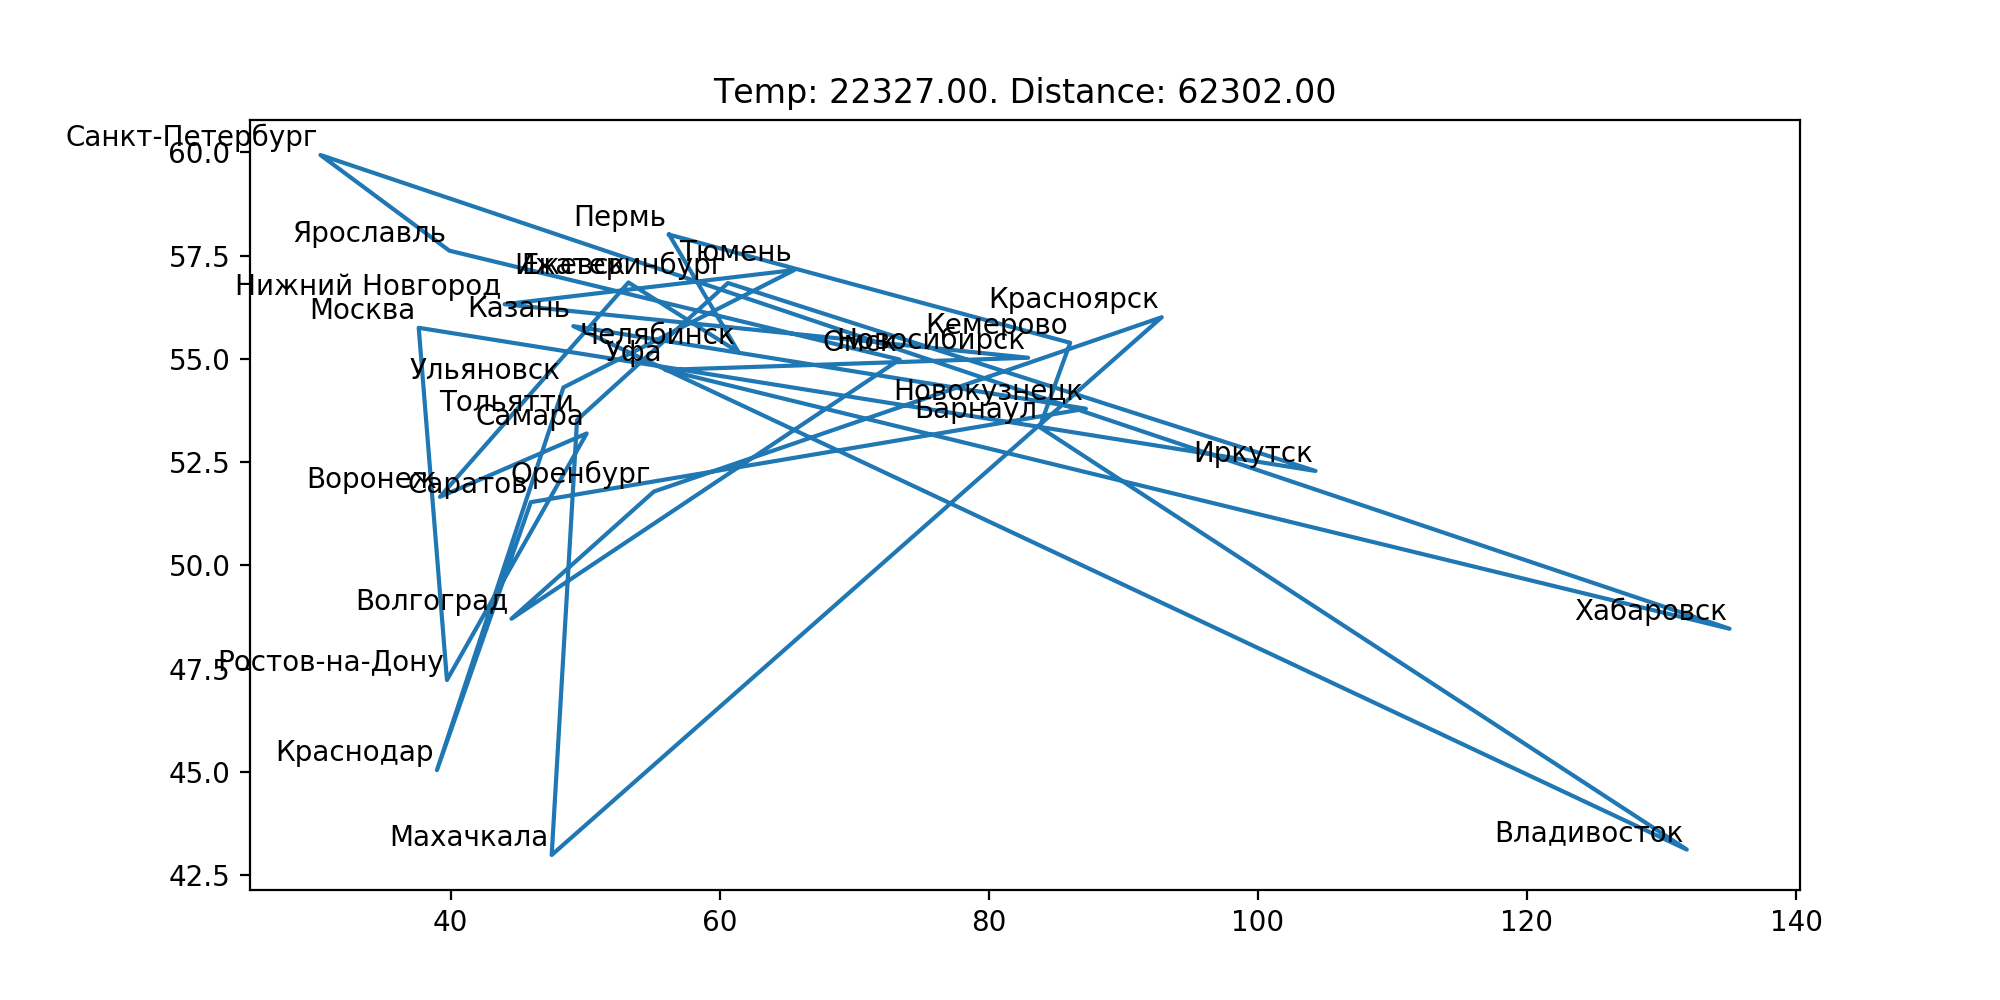

In [21]:
sol = sols[0.995]

show_results(0.995, sol)

paths = [v[1] for v in sol[2]]
temps = [v[2] for v in sol[2]]
dists = [v[0] for v in sol[2]]
labels = [data.loc[i]['Город'] for i in paths[0]]

fig, ax = plt.subplots(figsize=(10, 5))

x = [data.loc[i]['Долгота'] for i in paths[0] + [paths[0][0]]]
y = [data.loc[i]['Широта'] for i in paths[0] + [paths[0][0]]]
line, = ax.plot(x, y)
ax.set_title(f'Temp: {temps[0]:.2f}. Distance: {dists[0]:.2f}')
for label, x, y in zip(labels, x, y):
    ax.annotate(
        label,
        xy=(x, y), xytext=(-1, 1),
        textcoords='offset points', ha='right', va='bottom')

def animate(i):
    line.set_ydata([data.loc[j]['Широта'] for j in paths[i] + [paths[i][0]]]) 
    line.set_xdata([data.loc[j]['Долгота'] for j in paths[i] + [paths[i][0]]])
    ax.set_title(f'Temp: {temps[i]:.2f}. Distance: {dists[i]:.2f}')
    return line,


ani = animation.FuncAnimation(
    fig, animate, interval=1, blit=True, save_count=50)

plt.show()

Annealing rate is 0.999
Found solution is 21198.835511388308
Took 10390 iterations


<IPython.core.display.Javascript object>


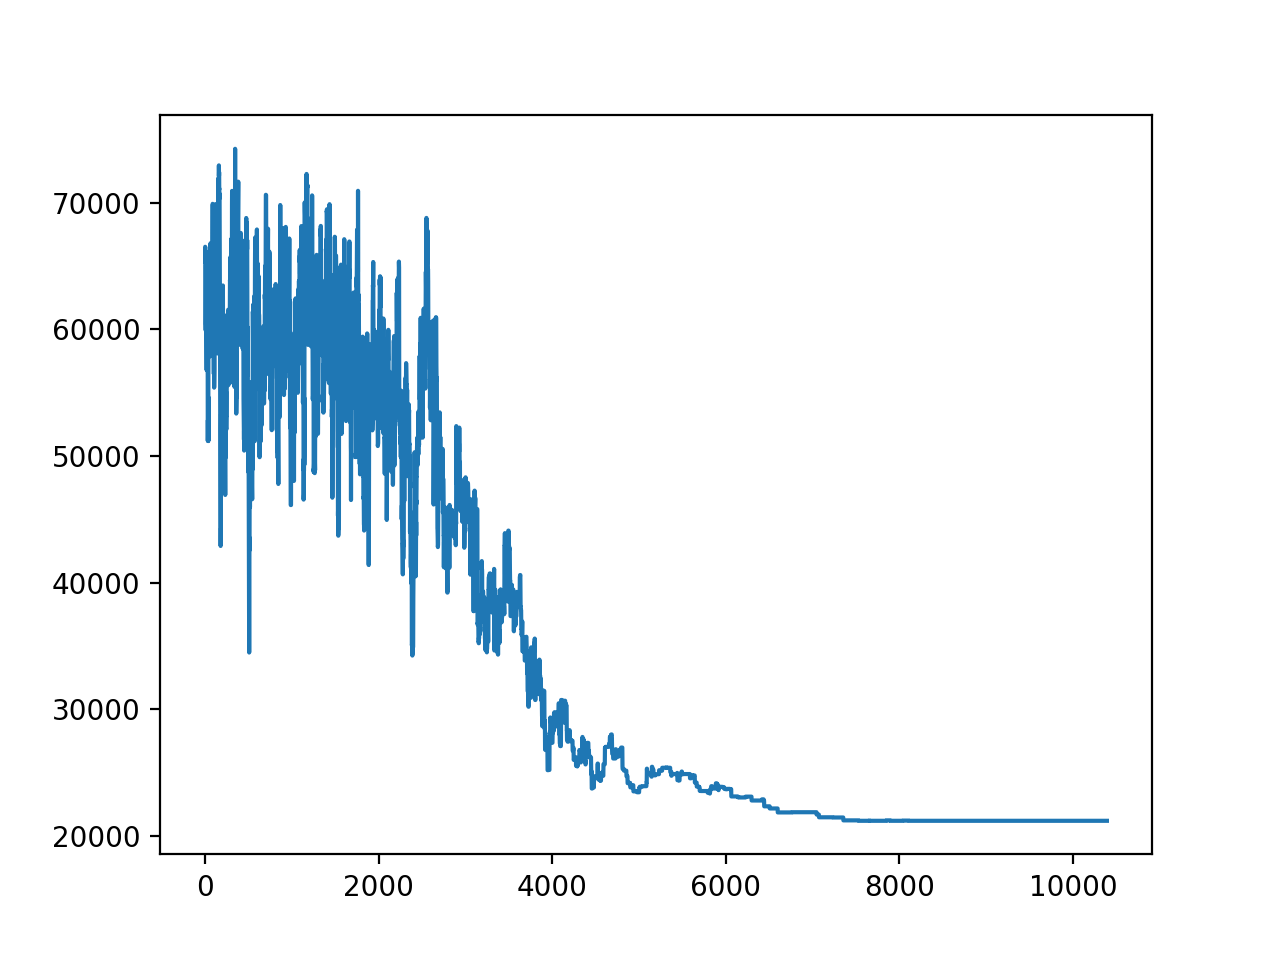

<IPython.core.display.Javascript object>


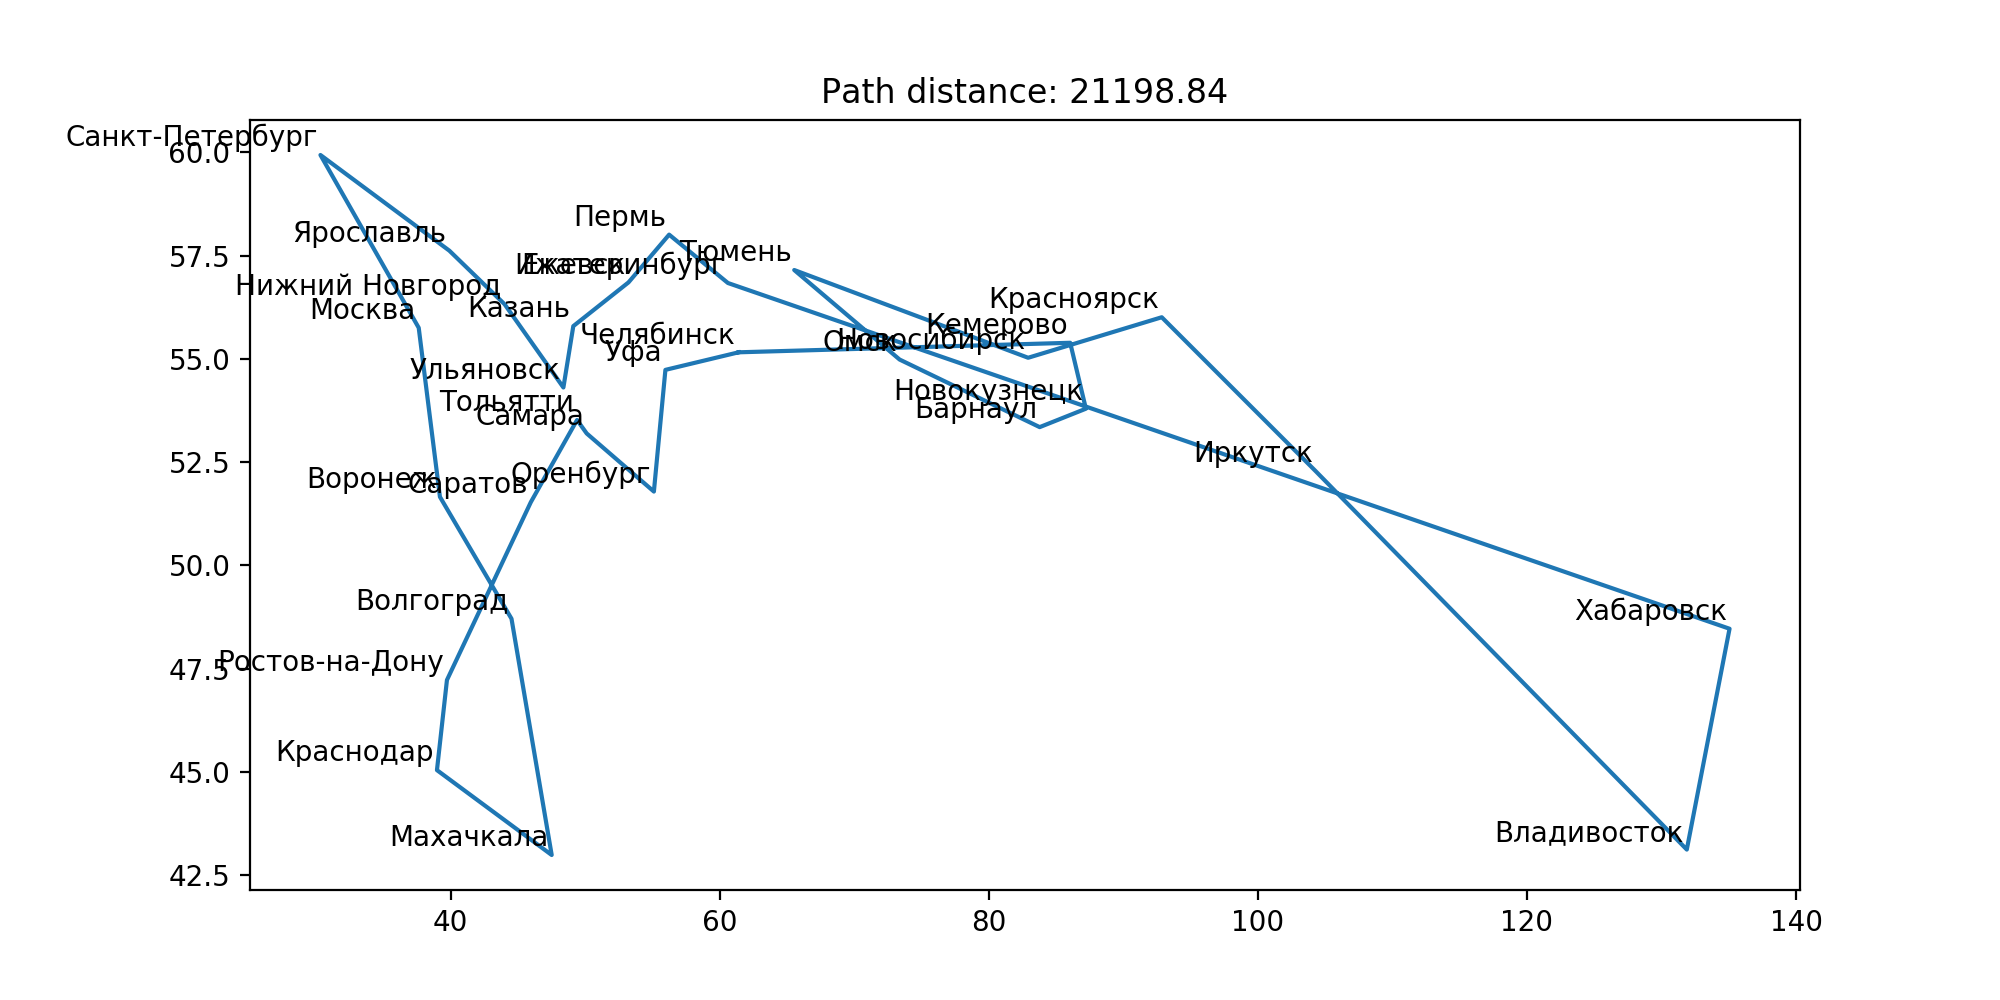

<IPython.core.display.Javascript object>


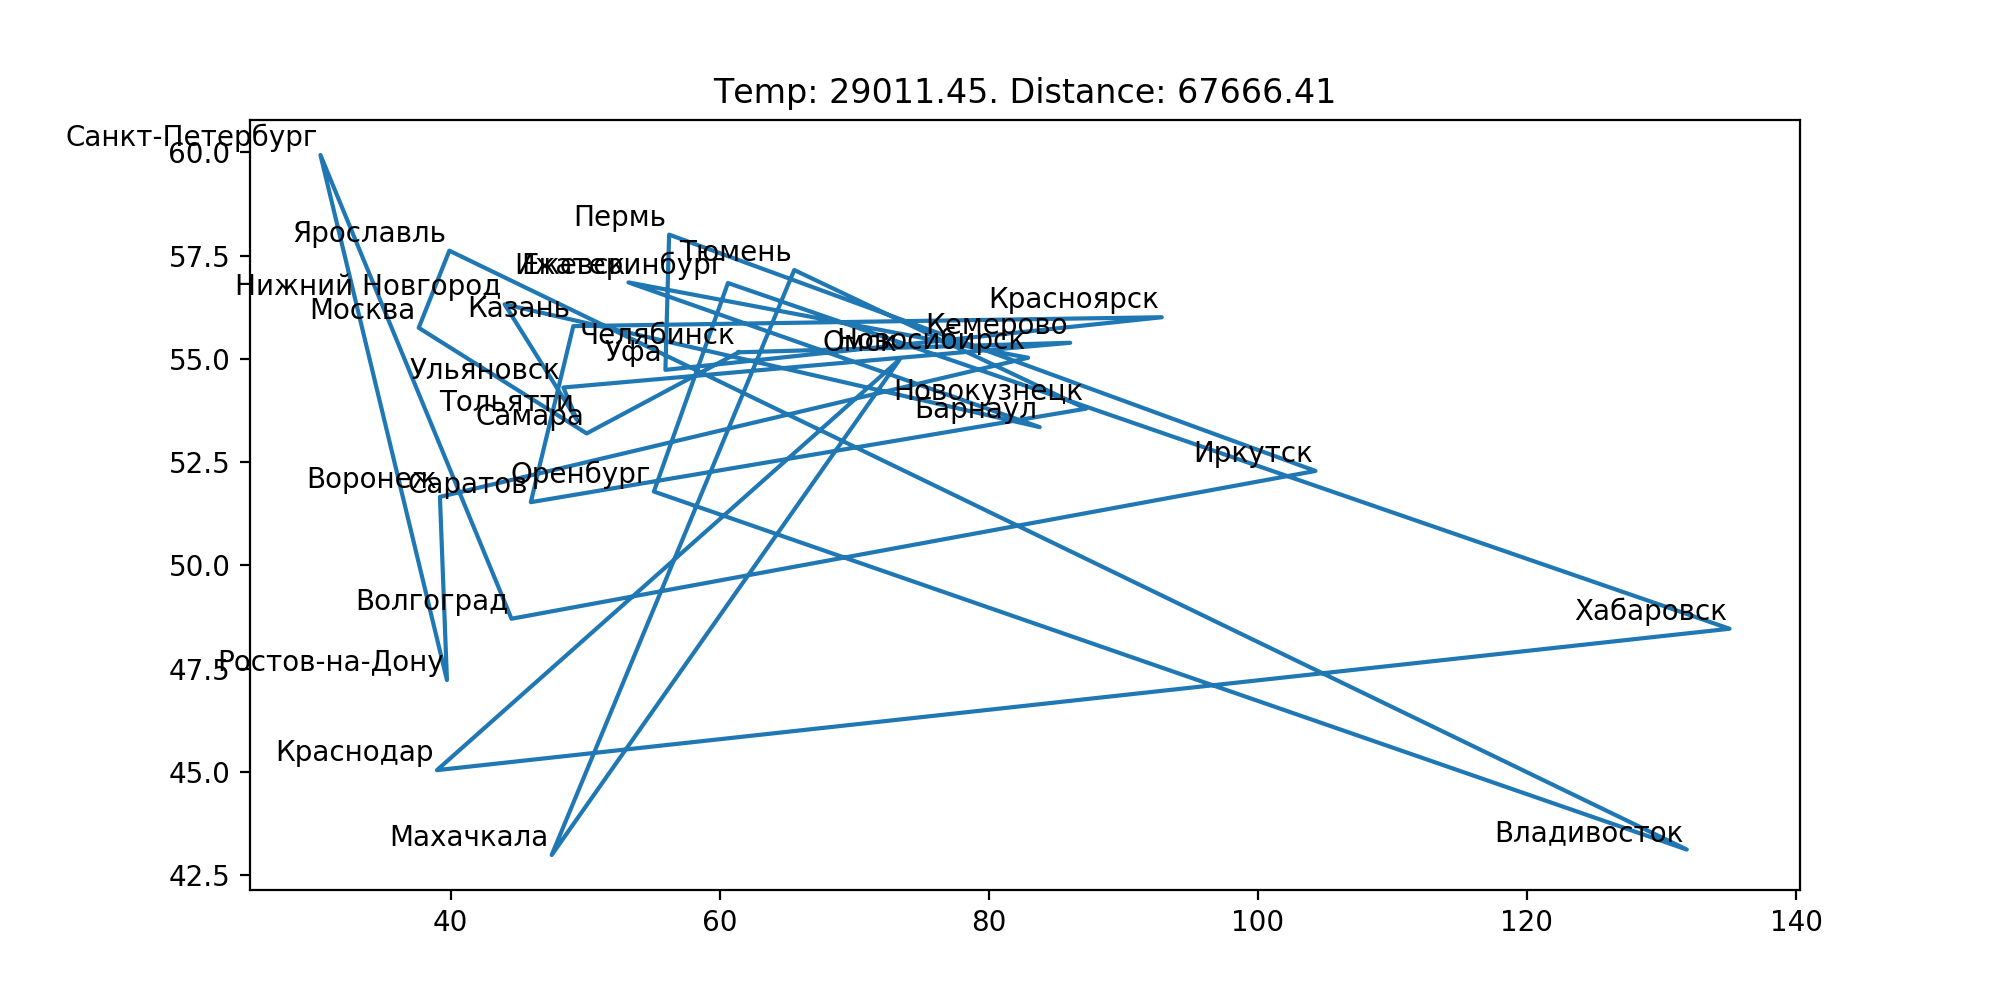

In [23]:
sol = sols[0.999]

show_results(0.999, sol)

paths = [v[1] for v in sol[2]]
temps = [v[2] for v in sol[2]]
dists = [v[0] for v in sol[2]]
labels = [data.loc[i]['Город'] for i in paths[0]]

fig, ax = plt.subplots(figsize=(10, 5))

x = [data.loc[i]['Долгота'] for i in paths[0] + [paths[0][0]]]
y = [data.loc[i]['Широта'] for i in paths[0] + [paths[0][0]]]
line, = ax.plot(x, y)
ax.set_title(f'Temp: {temps[0]:.2f}. Distance: {dists[0]:.2f}')
for label, x, y in zip(labels, x, y):
    ax.annotate(
        label,
        xy=(x, y), xytext=(-1, 1),
        textcoords='offset points', ha='right', va='bottom')

def animate(i):
    line.set_ydata([data.loc[j]['Широта'] for j in paths[i] + [paths[i][0]]]) 
    line.set_xdata([data.loc[j]['Долгота'] for j in paths[i] + [paths[i][0]]])
    ax.set_title(f'Temp: {temps[i]:.2f}. Distance: {dists[i]:.2f}')
    return line,


ani = animation.FuncAnimation(
    fig, animate, interval=1, blit=True, save_count=50)

plt.show()

Annealing rate is 0.9995
Found solution is 22184.99498128267
Took 20784 iterations


<IPython.core.display.Javascript object>


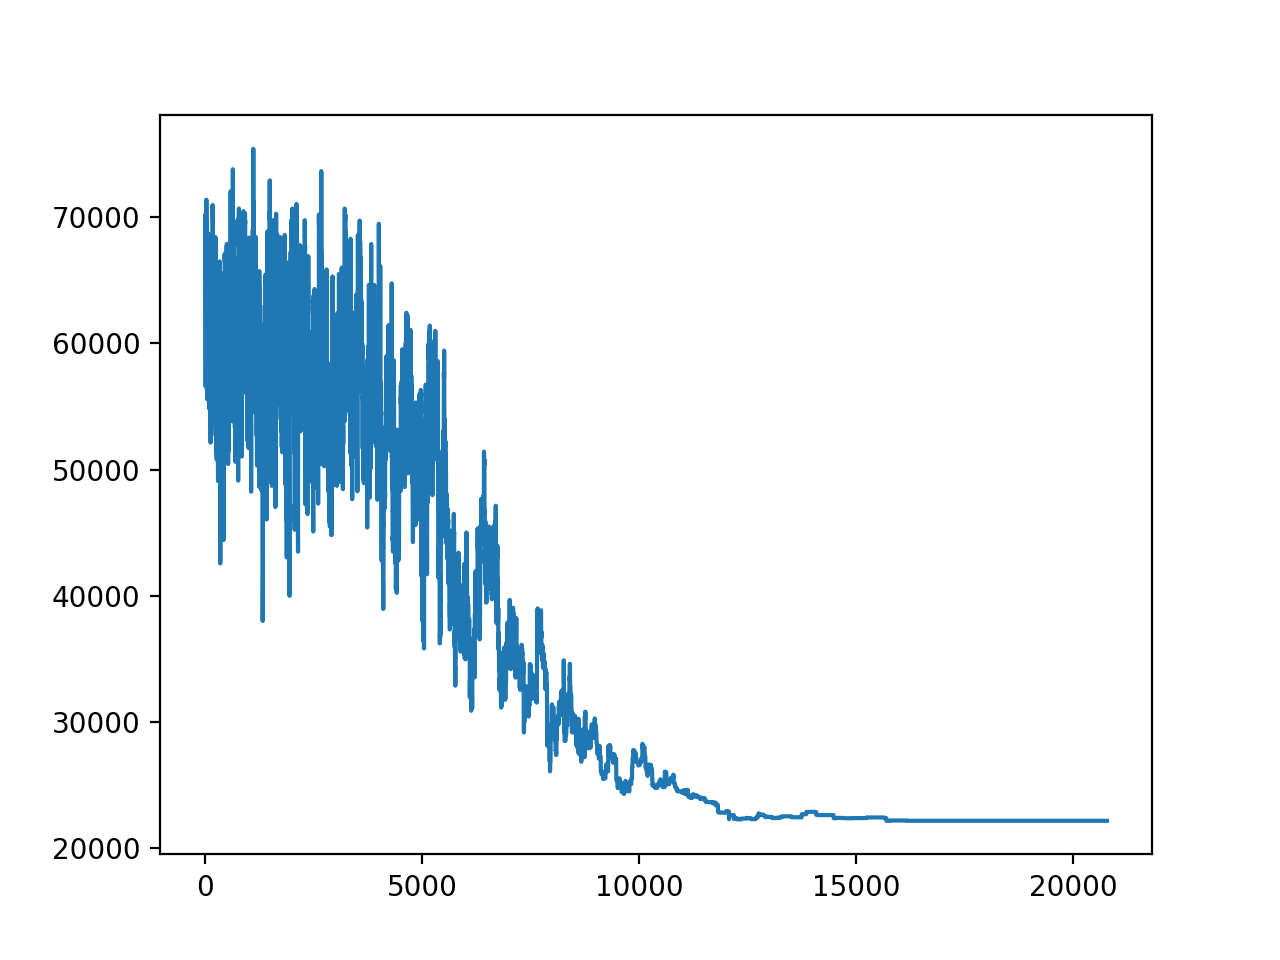

<IPython.core.display.Javascript object>


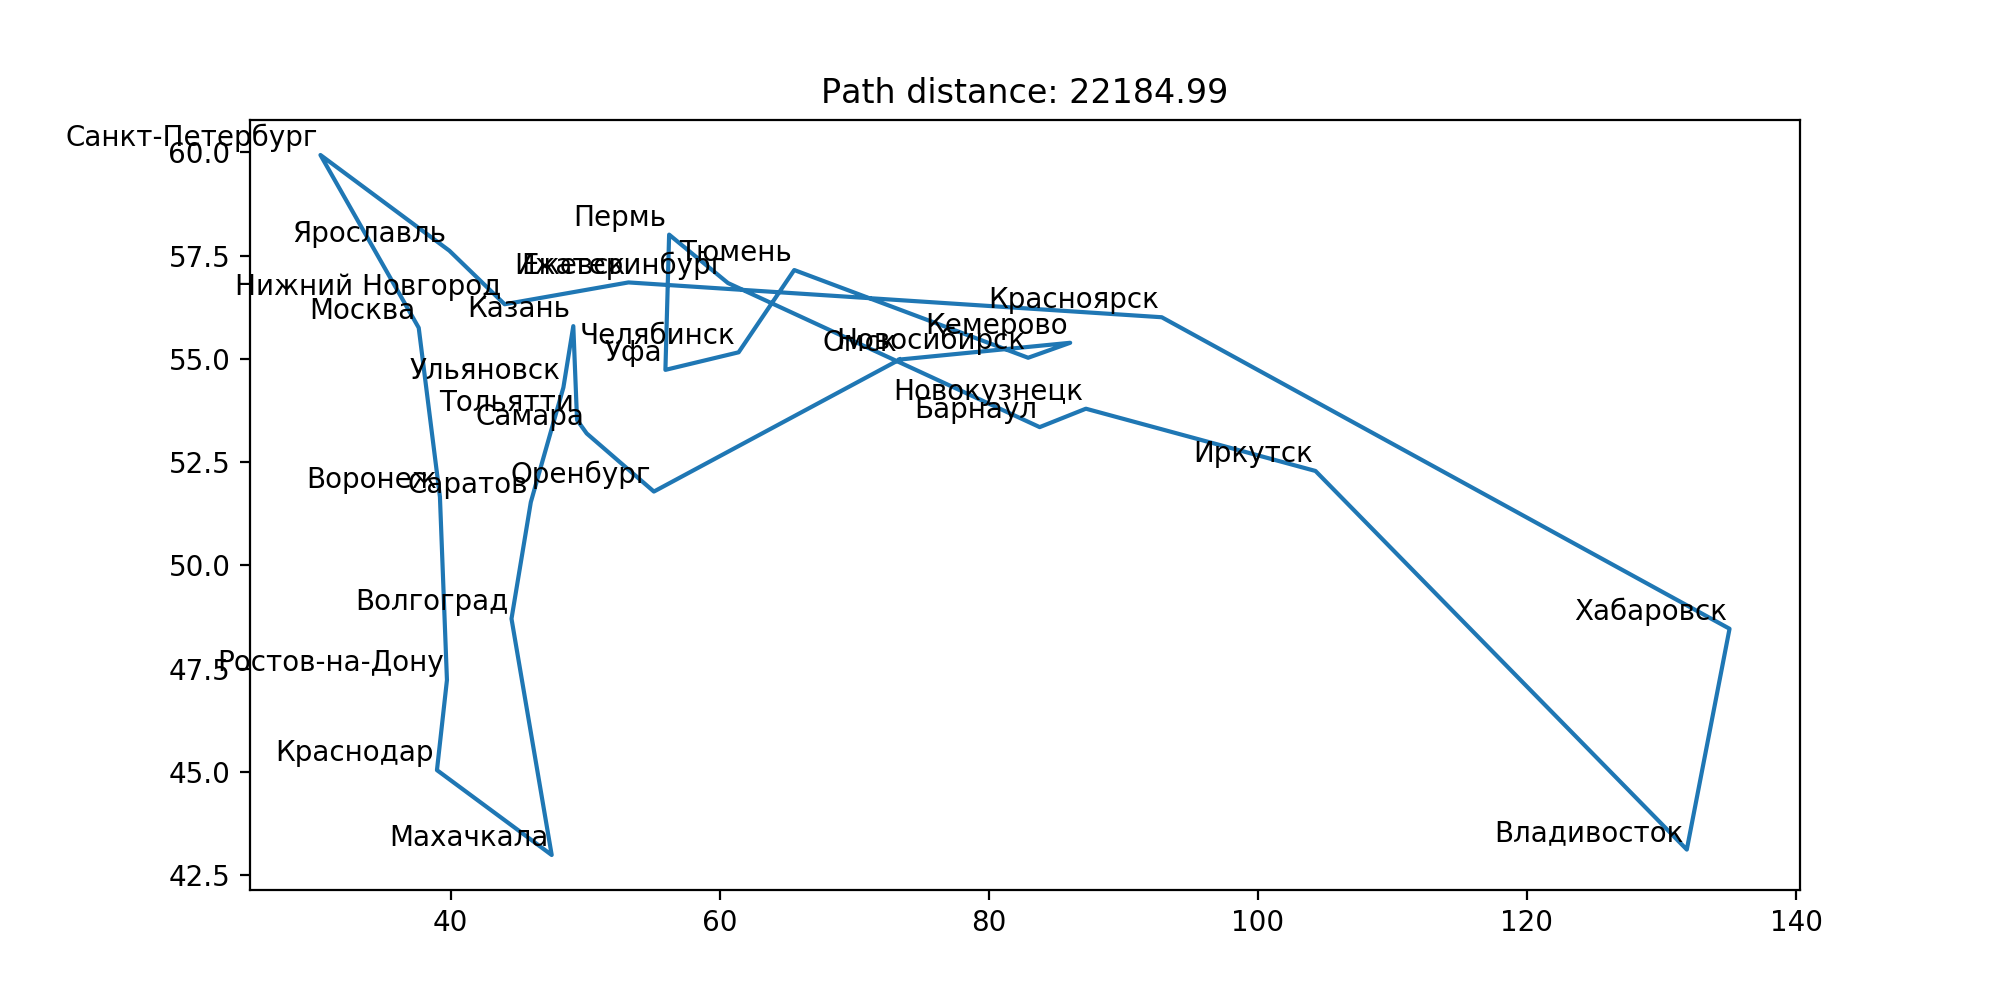

<IPython.core.display.Javascript object>


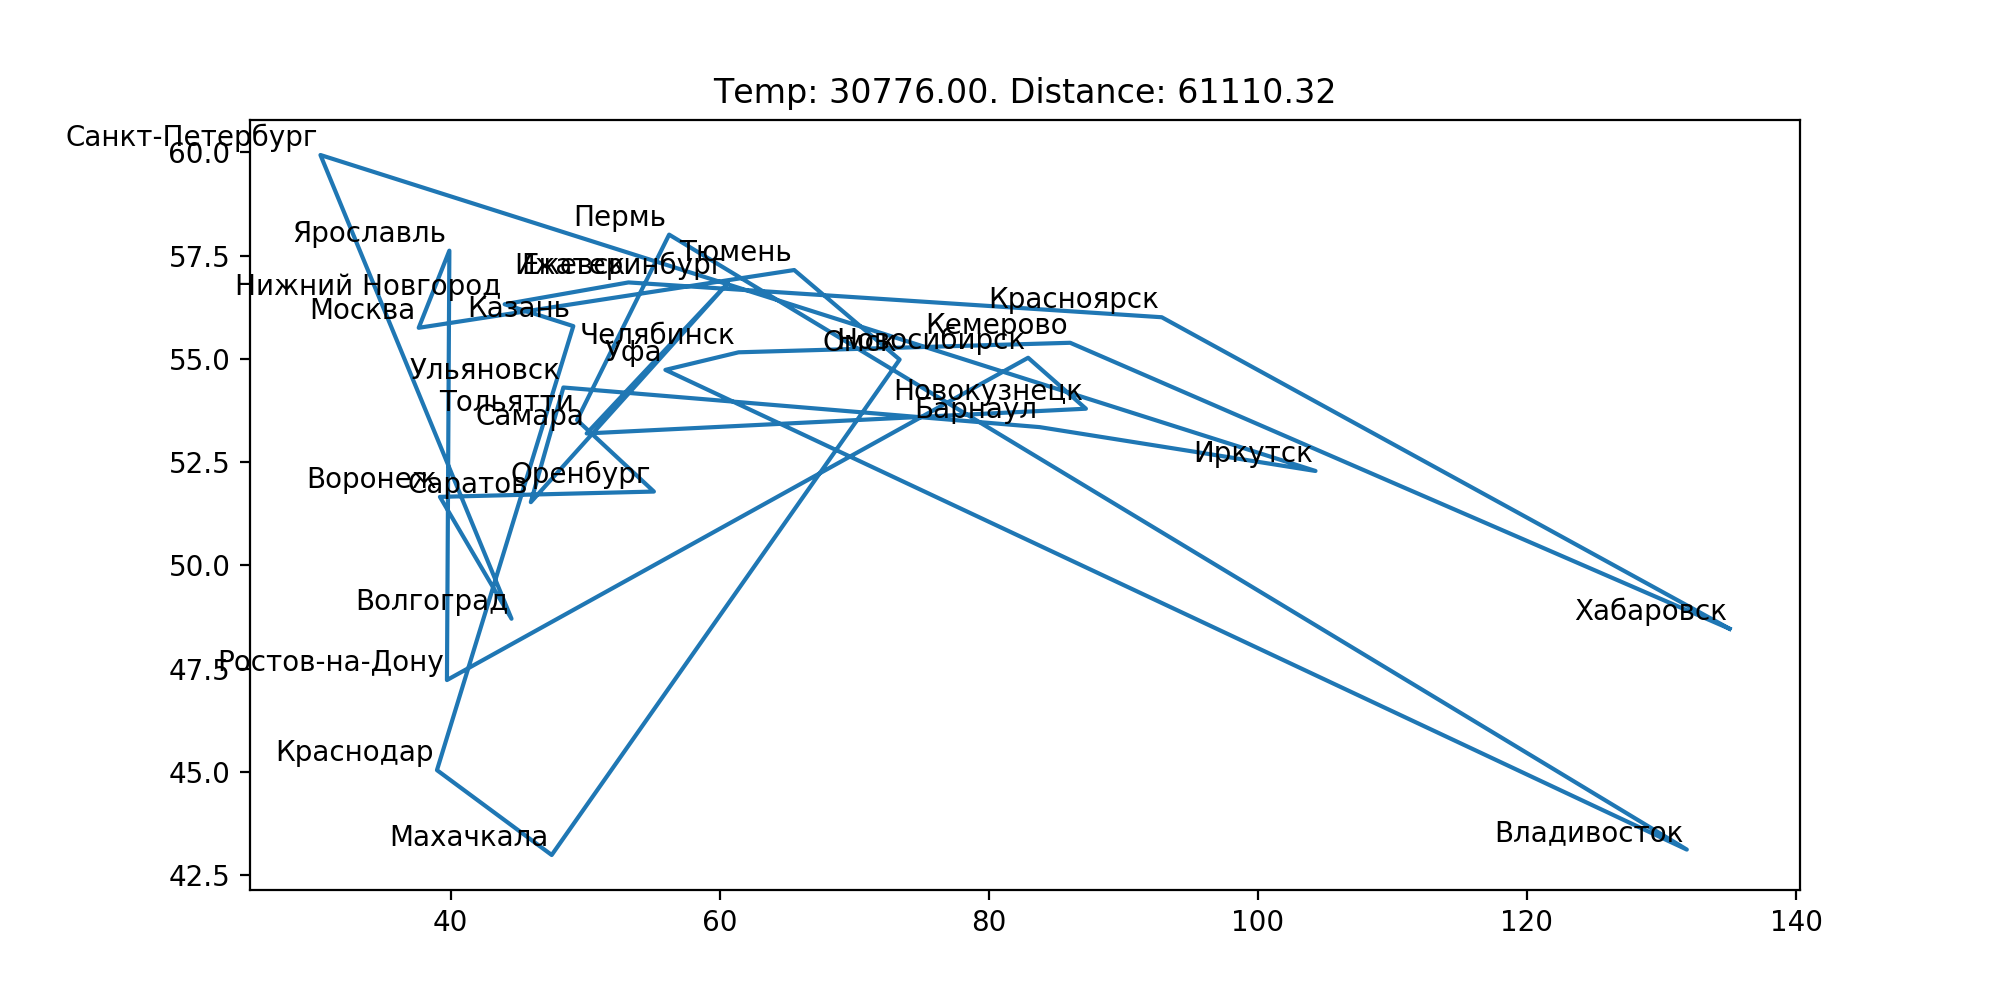

In [24]:
sol = sols[0.9995]

show_results(0.9995, sol)

paths = [v[1] for v in sol[2]]
temps = [v[2] for v in sol[2]]
dists = [v[0] for v in sol[2]]
labels = [data.loc[i]['Город'] for i in paths[0]]

fig, ax = plt.subplots(figsize=(10, 5))

x = [data.loc[i]['Долгота'] for i in paths[0] + [paths[0][0]]]
y = [data.loc[i]['Широта'] for i in paths[0] + [paths[0][0]]]
line, = ax.plot(x, y)
ax.set_title(f'Temp: {temps[0]:.2f}. Distance: {dists[0]:.2f}')
for label, x, y in zip(labels, x, y):
    ax.annotate(
        label,
        xy=(x, y), xytext=(-1, 1),
        textcoords='offset points', ha='right', va='bottom')

def animate(i):
    line.set_ydata([data.loc[j]['Широта'] for j in paths[i] + [paths[i][0]]]) 
    line.set_xdata([data.loc[j]['Долгота'] for j in paths[i] + [paths[i][0]]])
    ax.set_title(f'Temp: {temps[i]:.2f}. Distance: {dists[i]:.2f}')
    return line,


ani = animation.FuncAnimation(
    fig, animate, interval=1, blit=True, save_count=50)

plt.show()